In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridSpec

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
pd.options.display.max_columns = 40

In [4]:
data_path = "../data/Customer-Churn-Records.csv"
data = pd.read_csv(data_path)
data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0        101348.88       1         1                   2   DIAMOND   
1        112542.58       0         1                   3   DIAMOND   
2        113931.57       1         1                   3   DIAMOND   
3         93826.63       0         0                   5      GOLD   
4         79084.10       0         0                   5      GOLD   

   Point Earned  
0           464  
1           456  
2           377  
3           350  
4           425

# 1. Data Preprocessing

In [5]:
data.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 1, inplace = True)

In [6]:
def resumetable(df):    
    print(f'data shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['data type'])
    summary = summary.rename(columns = {'index': 'feature'})
    summary['num_NaN'] = df.isnull().sum().values
    summary['num_unique'] = df.nunique().values
    summary['data category'] = None
    for col in df.columns:
        if col == 'Exited':
            summary.loc[col, 'data category'] = 'Binary'
        elif df[col].dtype == object:
            summary.loc[col, 'data category'] = 'Categorical'
        elif df[col].dtype == float:
            summary.loc[col, 'data category'] = 'Numeric'
        elif df[col].dtype == int:
            summary.loc[col, 'data category'] = 'Integer'

    
    return summary

In [7]:
summary = resumetable(data)
summary

data shape: (10000, 15)


data type  num_NaN  num_unique data category
CreditScore            int64        0         460       Integer
Geography             object        0           3   Categorical
Gender                object        0           2   Categorical
Age                    int64        0          70       Integer
Tenure                 int64        0          11       Integer
Balance              float64        0        6382       Numeric
NumOfProducts          int64        0           4       Integer
HasCrCard              int64        0           2       Integer
IsActiveMember         int64        0           2       Integer
EstimatedSalary      float64        0        9999       Numeric
Exited                 int64        0           2        Binary
Complain               int64        0           2       Integer
Satisfaction Score     int64        0           5       Integer
Card Type             object        0           4   Categorical
Point Earned           int64        0         785       Integer

We can conclude that this dataset does not include any missing values. Additionally, we identified some categorical variables (Geography, Gender, Card Type). We also need to simplify the column names for easier recognition

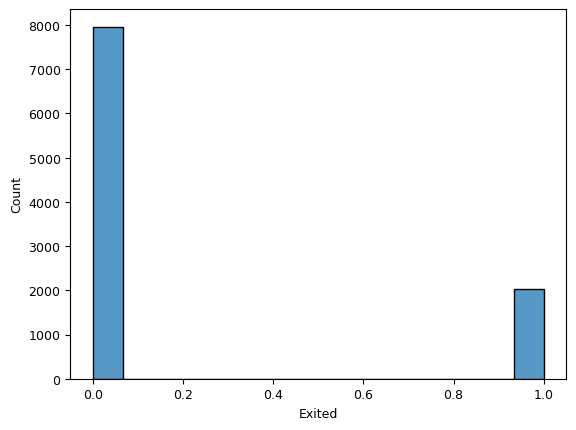

In [327]:
sns.histplot(data['Exited']);

Here, the plot suggests that the target variable is in an inbalance status, so we should focus more on the small proportion of target value 1. 

In [8]:
zero = data[data['Balance'] == 0]

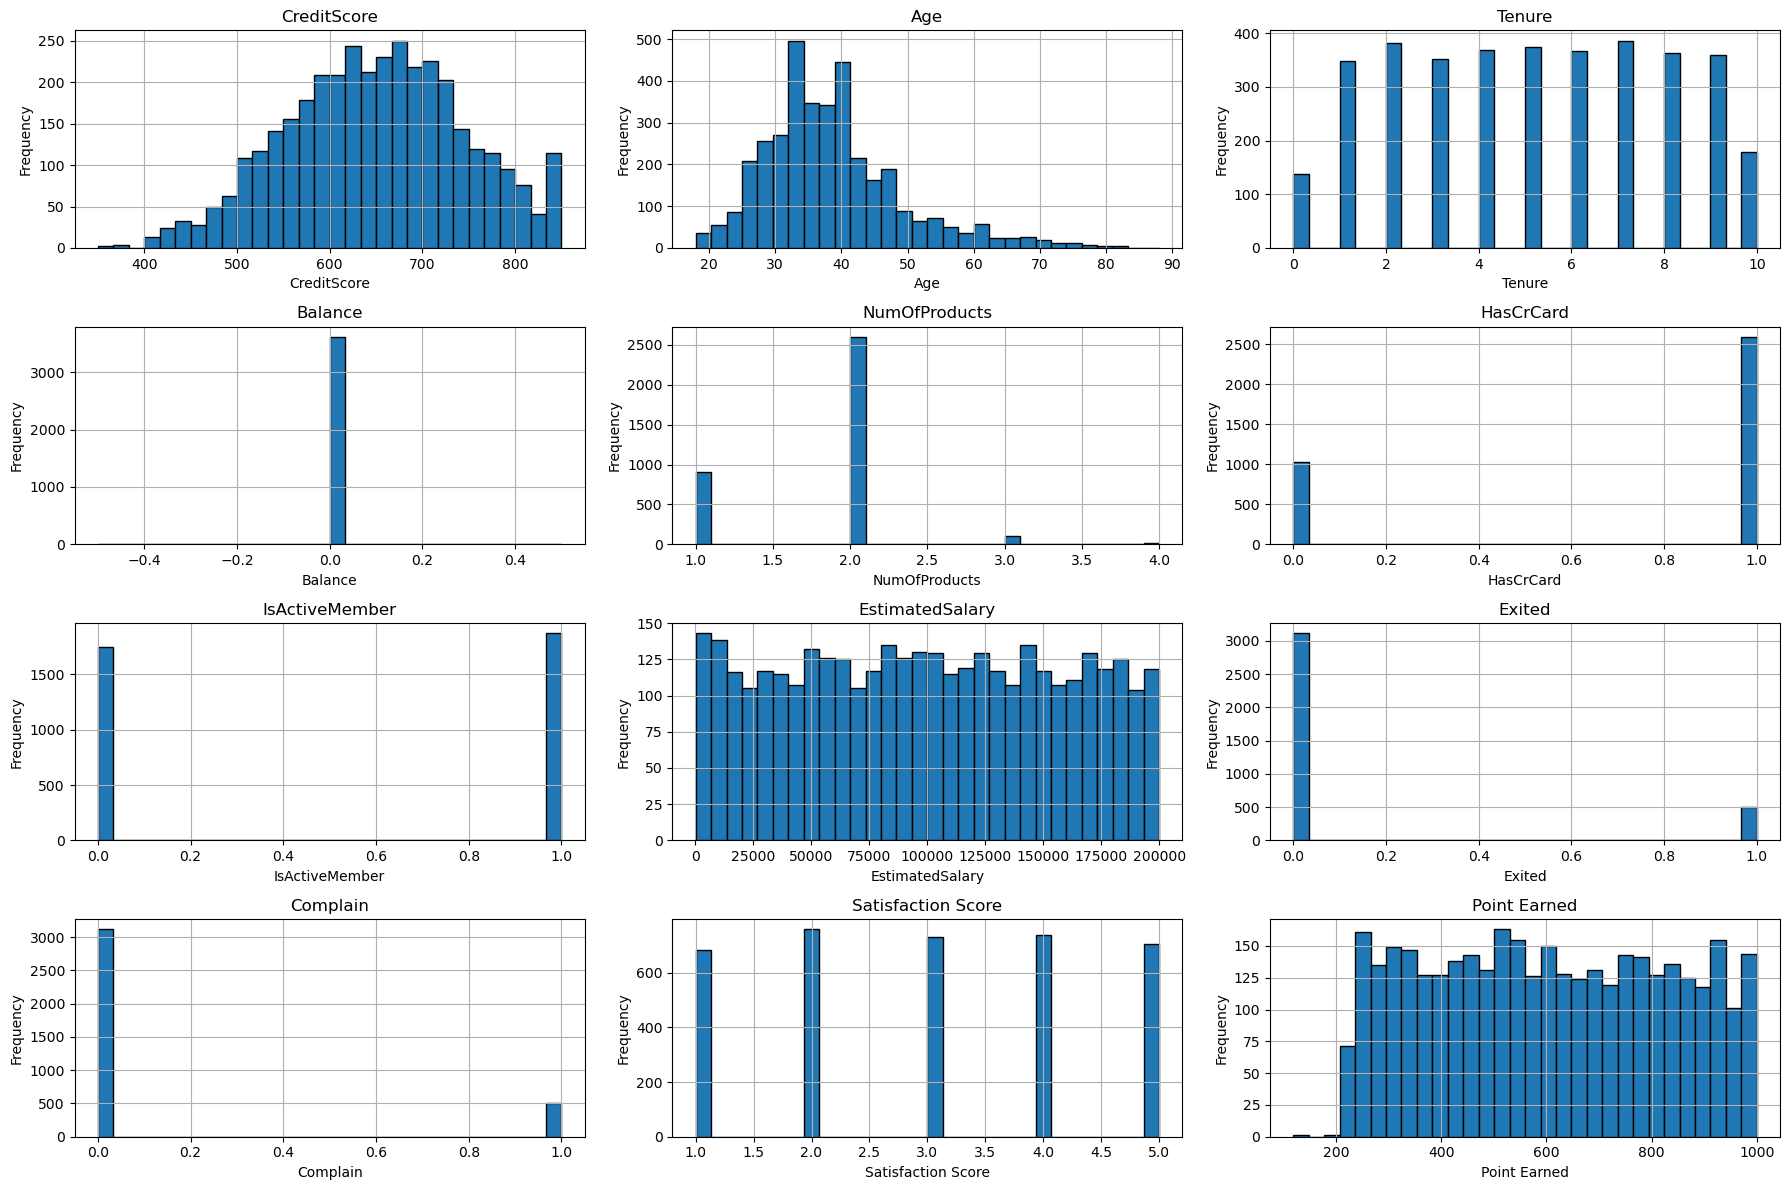

In [9]:
numeric_columns = zero.select_dtypes(include=['float64', 'int64']).columns

# Re-plot using subplots with a larger figure to avoid scrolling
plt.figure(figsize=(18, 12))  # Larger figure to fit all plots
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)  # Adjust grid size to fit all features
    zero[column].hist(bins=30, edgecolor='black')
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



In [330]:
data['Exited'].value_counts()

Exited
0    7962
1    2038
Name: count, dtype: int64

In [331]:
round(data.describe(), 2)

CreditScore       Age    Tenure    Balance  NumOfProducts  HasCrCard  \
count     10000.00  10000.00  10000.00   10000.00       10000.00   10000.00   
mean        650.53     38.92      5.01   76485.89           1.53       0.71   
std          96.65     10.49      2.89   62397.41           0.58       0.46   
min         350.00     18.00      0.00       0.00           1.00       0.00   
25%         584.00     32.00      3.00       0.00           1.00       0.00   
50%         652.00     37.00      5.00   97198.54           1.00       1.00   
75%         718.00     44.00      7.00  127644.24           2.00       1.00   
max         850.00     92.00     10.00  250898.09           4.00       1.00   

       IsActiveMember  EstimatedSalary   Exited  Complain  Satisfaction Score  \
count        10000.00         10000.00  10000.0   10000.0            10000.00   
mean             0.52        100090.24      0.2       0.2                3.01   
std              0.50         57510.49      0.4       0.4                1.41   
min              0.00            11.58      0.0       0.0                1.00   
25%              0.00         51002.11      0.0       0.0                2.00   
50%              1.00        100193.92      0.0       0.0                3.00   
75%              1.00        149388.25      0.0       0.0                4.00   
max              1.00        199992.48      1.0       1.0                5.00   

       Point Earned  
count      10000.00  
mean         606.52  
std          225.92  
min          119.00  
25%          410.00  
50%          605.00  
75%          801.00  
max         1000.00

We have a binary outcome here: 1 indicates that the customer left the bank, while 0 means the customer did not. The results suggest that the number of customers who left the bank is four times greater than the number of customers who did not churn based on this dataset.

### One-hot encoding (categorical data)

In [11]:
data = pd.get_dummies(data, columns=['Geography', 'Gender', 'Card Type'])

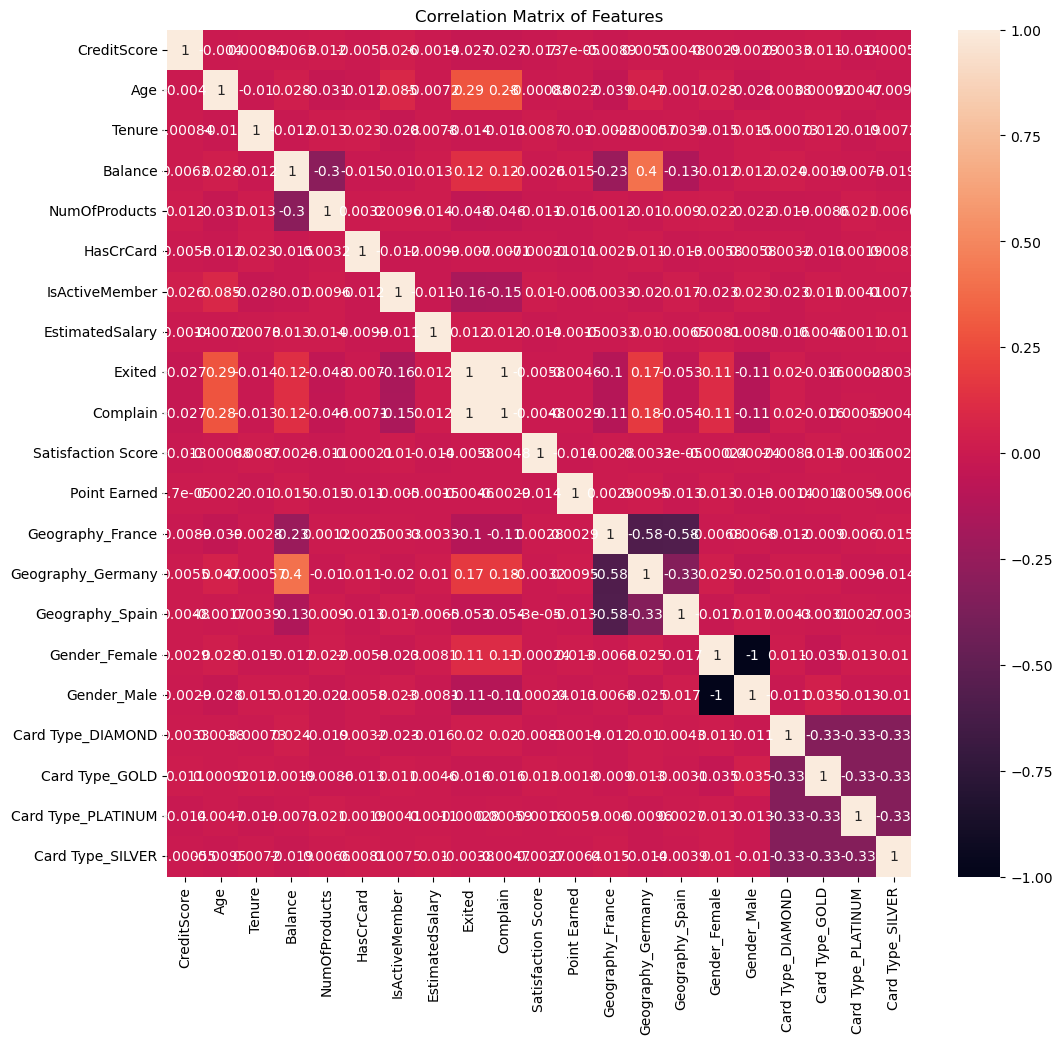

In [13]:
corr_matrix = data.corr()

plt.figure(figsize=(12, 11))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
# data.drop(['Complain'], axis = 1, inplace = True) 보류 

### Data Scaling

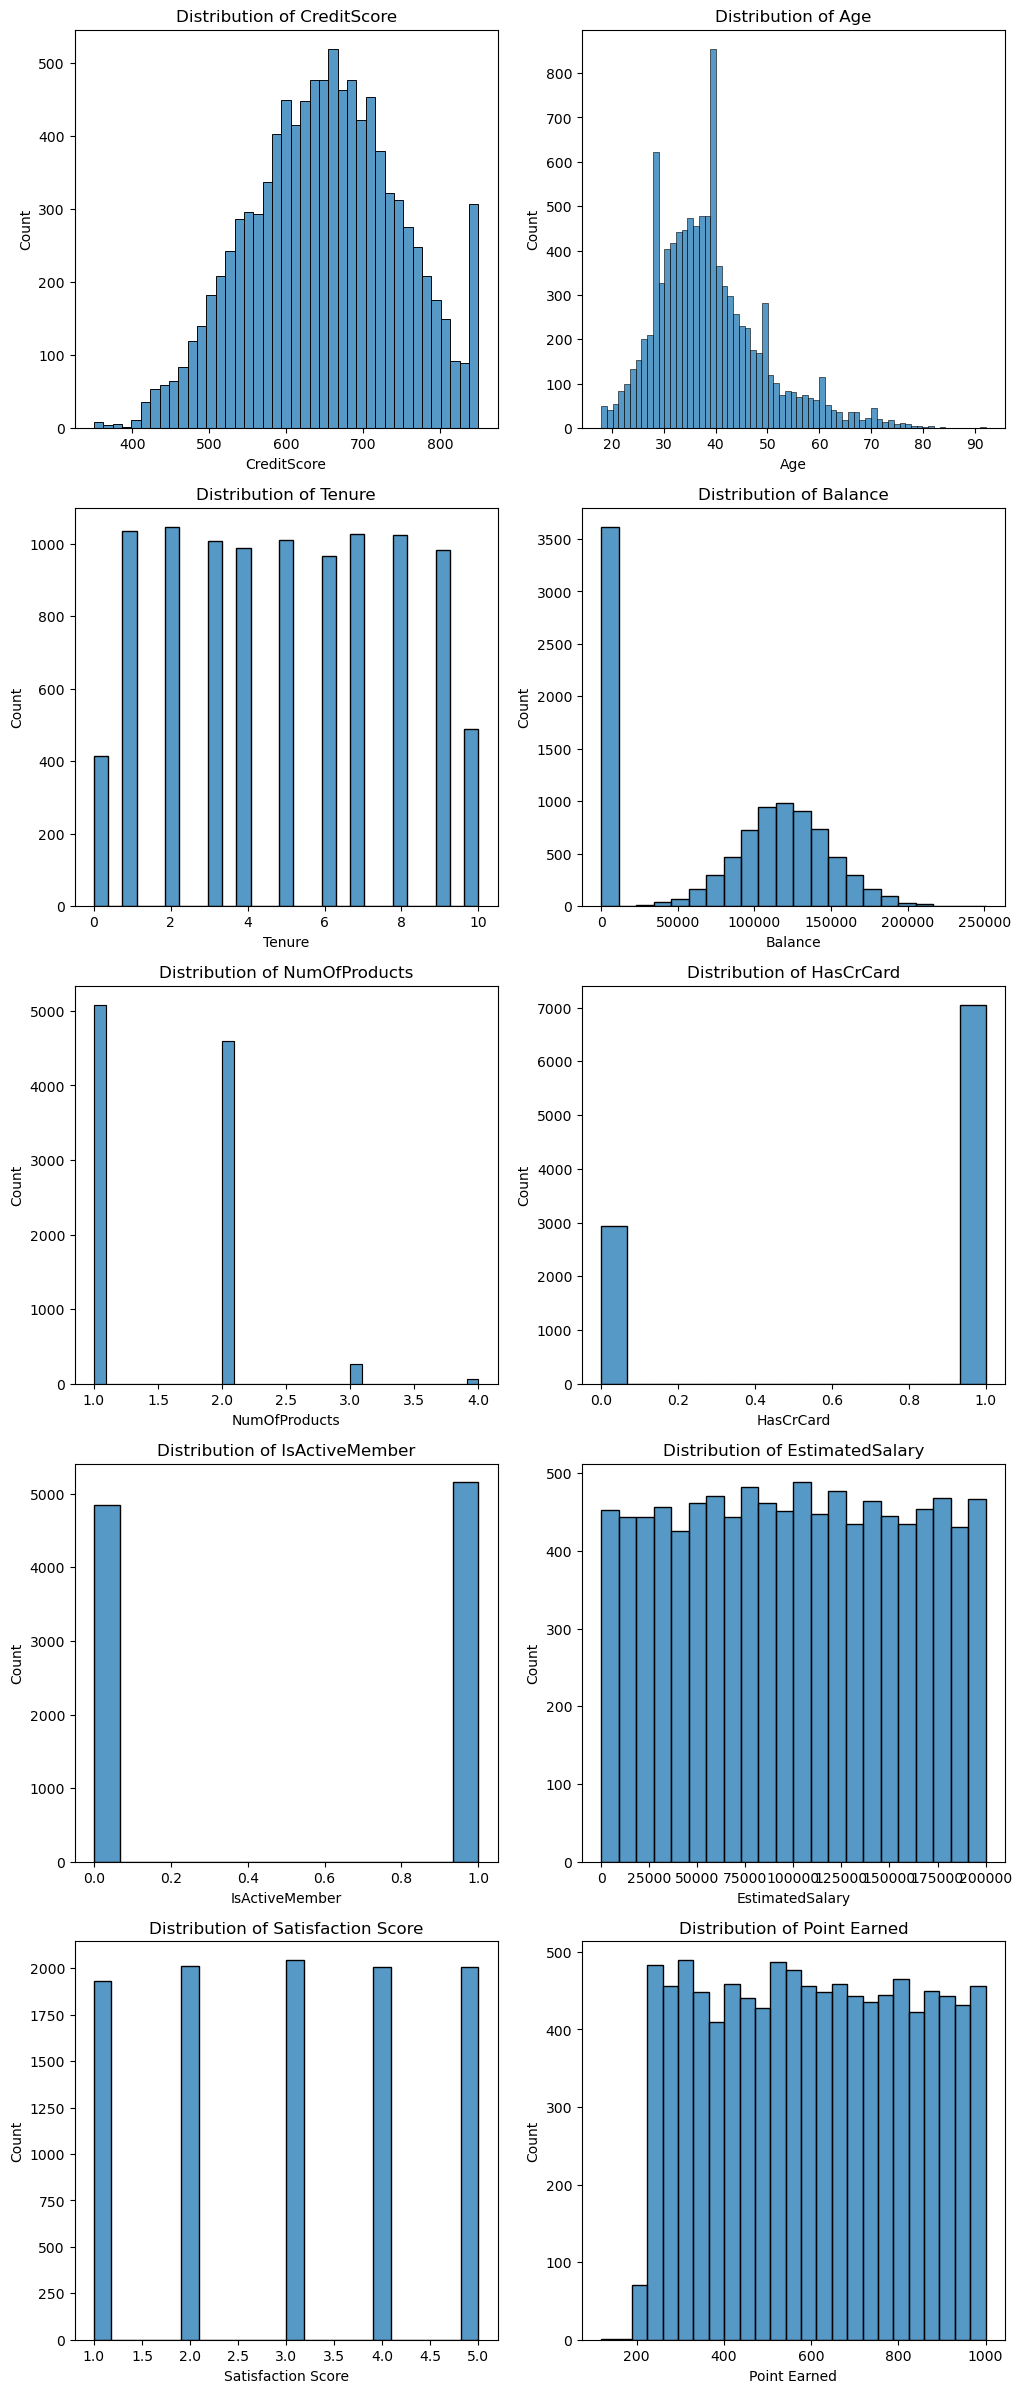

In [14]:
numeric_columns = summary[summary['data category'].isin(['Numeric', 'Integer'])].index.tolist()

if "Complain" in numeric_columns:
     numeric_columns.remove("Complain")

fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(12, 30))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col],ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

### 우선 스케일링또한 보류

- numofproducts 변수는 1, 2, 3, 4 등의 숫자간에 discrete 성격을 보여주기때문에 범주형 변수로 간주한다.
satisfaction score 변수도 명확한 범주를 보여줌. (1, 2, 3, 4, 5) 
이 두 변수는 원-핫 인코딩을 진행

- Balance 변수를 보면 0에 많은 데이터가 몰려있는 걸 알 수 있다. 이는 모델이 잔액 0 여부를 구분하도록 하기 위해 이진 변수로 추가

- CreditScore: Standard Scaling 

- Age: Standard Scaling 
    WHY? Age는 정규 분포에 가깝고 나이 간의 상대적 차이를 유지하는게 중요해보임. 그리고 30~40대에 몰려있는게 가장 큰 이유

- EstimatedSalary: Min-Max Scaling 
    WHY? 분포가 다른 피처들 중 가장 균등함
  
- Point Earned: Robust Scaling 
    WHY? Point Earned는 최소값 근처에 데이터가 적고 나머지 값들은 균등하게 분포되어 있어 이상치의 영향을 줄이기 위해 Robust Scaling 사용

- Balance: Robust Scaling 
    WHY? Balance는 0에 많은 데이터가 몰려 있어서 중앙값과 IQR을 기준으로 스케일링하여 이상치의 영향을 줄이기


In [15]:
data = pd.get_dummies(data, columns=['NumOfProducts', 'Satisfaction Score'])

In [303]:
# standard_scaler = StandardScaler()
# min_max_scaler = MinMaxScaler()
# robust_scaler = RobustScaler()

# data[['CreditScore', 'Age']] = standard_scaler.fit_transform(data[['CreditScore', 'Age']])
# data['EstimatedSalary'] = min_max_scaler.fit_transform(data[['EstimatedSalary']])
# data[['Point Earned', 'Balance']] = robust_scaler.fit_transform(data[['Point Earned', 'Balance']])

In [16]:
data.head()

CreditScore  Age  Tenure    Balance  HasCrCard  IsActiveMember  \
0          619   42       2       0.00          1               1   
1          608   41       1   83807.86          0               1   
2          502   42       8  159660.80          1               0   
3          699   39       1       0.00          0               0   
4          850   43       2  125510.82          1               1   

   EstimatedSalary  Exited  Complain  Point Earned  Geography_France  \
0        101348.88       1         1           464              True   
1        112542.58       0         1           456             False   
2        113931.57       1         1           377              True   
3         93826.63       0         0           350              True   
4         79084.10       0         0           425             False   

   Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  \
0              False            False           True        False   
1              False             True           True        False   
2              False            False           True        False   
3              False            False           True        False   
4              False             True           True        False   

   Card Type_DIAMOND  Card Type_GOLD  Card Type_PLATINUM  Card Type_SILVER  \
0               True           False               False             False   
1               True           False               False             False   
2               True           False               False             False   
3              False            True               False             False   
4              False            True               False             False   

   NumOfProducts_1  NumOfProducts_2  NumOfProducts_3  NumOfProducts_4  \
0             True            False            False            False   
1             True            False            False            False   
2            False            False             True            False   
3            False             True            False            False   
4             True            False            False            False   

   Satisfaction Score_1  Satisfaction Score_2  Satisfaction Score_3  \
0                 False                  True                 False   
1                 False                 False                  True   
2                 False                 False                  True   
3                 False                 False                 False   
4                 False                 False                 False   

   Satisfaction Score_4  Satisfaction Score_5  
0                 False                 False  
1                 False                 False  
2                 False                 False  
3                 False                  True  
4                 False                  True

### Feature Engineering

In [17]:
# data['Zero_Balance'] = (data['Balance'] == 0).astype(int)

In [19]:
data.head()

CreditScore  Age  Tenure    Balance  HasCrCard  IsActiveMember  \
0          619   42       2       0.00          1               1   
1          608   41       1   83807.86          0               1   
2          502   42       8  159660.80          1               0   
3          699   39       1       0.00          0               0   
4          850   43       2  125510.82          1               1   

   EstimatedSalary  Exited  Complain  Point Earned  Geography_France  \
0        101348.88       1         1           464              True   
1        112542.58       0         1           456             False   
2        113931.57       1         1           377              True   
3         93826.63       0         0           350              True   
4         79084.10       0         0           425             False   

   Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  \
0              False            False           True        False   
1              False             True           True        False   
2              False            False           True        False   
3              False            False           True        False   
4              False             True           True        False   

   Card Type_DIAMOND  Card Type_GOLD  Card Type_PLATINUM  Card Type_SILVER  \
0               True           False               False             False   
1               True           False               False             False   
2               True           False               False             False   
3              False            True               False             False   
4              False            True               False             False   

   NumOfProducts_1  NumOfProducts_2  NumOfProducts_3  NumOfProducts_4  \
0             True            False            False            False   
1             True            False            False            False   
2            False            False             True            False   
3            False             True            False            False   
4             True            False            False            False   

   Satisfaction Score_1  Satisfaction Score_2  Satisfaction Score_3  \
0                 False                  True                 False   
1                 False                 False                  True   
2                 False                 False                  True   
3                 False                 False                 False   
4                 False                 False                 False   

   Satisfaction Score_4  Satisfaction Score_5  
0                 False                 False  
1                 False                 False  
2                 False                 False  
3                 False                  True  
4                 False                  True

In [307]:
# bins = [0, 2, 4, 6, 8, 10]
# labels = ['0-2', '3-4', '5-6', '7-8', '9-10']
# data['Tenure_bin'] = pd.cut(data['Tenure'], bins = bins, labels = labels, include_lowest = True)
# data = pd.get_dummies(data, columns = ['Tenure_bin'], prefix = 'tenure')

### Feature importance by random forest

In [20]:
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

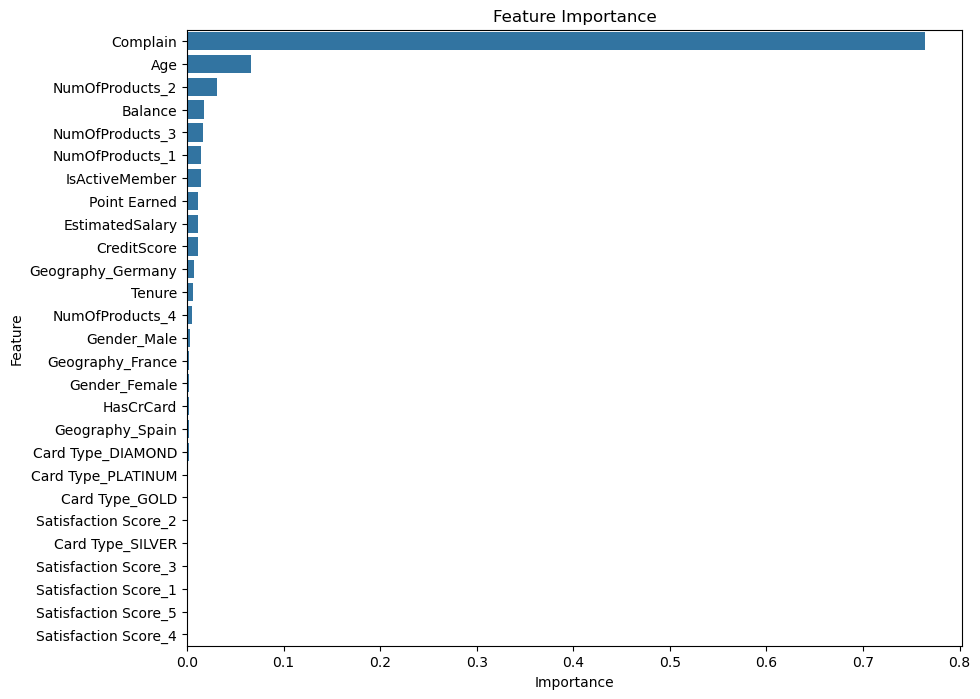

In [21]:
plt.figure(figsize=(10, 8))
sns.barplot(feature_importance_df, x = 'Importance', y = 'Feature')
plt.title('Feature Importance')
plt.show();

# 2. Reinforcement Learning Environment Setup